In [170]:
import os

import torch
import pandas as pd
import numpy as np

from collections import Counter

## OPTIONS

In [171]:
nrows = 1000
min_freq = 1

train_data_path = "../../data/toy_dataset/data/train_seq30.csv"
valid_data_path = "../../data/toy_dataset/data/test_seq30.csv"

model_save_path = './sample_model/simple_lstm_201215'
results_save_path = "./sample_results/simple_results_201215"
batch_size = 64
n_epochs = 5

embedding_dim = 8
hidden_dim = 16
bidirectional = True
dropout = 0.3

target_colname = 'label'
uid_colname = 'patient_id'
x_inputs = [str(x) for x in range(29, -1, -1)]
target_value = '1'

In [172]:
for fp in [model_save_path, results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f'New directory created: {fp}')
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

New directory created: ./sample_model/simple_lstm_201215
New directory created: ./sample_results/simple_results_201215
Cuda available: True


## Create Vocab

equivalent to model.create_word_id_dict

In [173]:
datapath = train_data_path
rev = False

In [174]:
def valid_token(t):
    if len(t) == 0 or t.lower() == "<pad>":
        return False
    return True

In [175]:
token_list = []
with open(datapath, "r") as f:
    # determine column mapping
    header = f.readline()
    header = [h.replace(" ", "").replace("\n", "") for h in header.split(",")]

    target_index = header.index(target_colname)

    uid_index = header.index(uid_colname)

    x_idxes = []
    for colname in x_inputs:
        x_idxes.append(header.index(colname))

    # start processing 
    line = f.readline()
    invalid_uid = 0
    deaths = 0
    while line:
        if 'death' in line:
            deaths += 1
            pass

        tokens = line.split(",")

        if len(tokens[uid_index]) == 0:
            invalid_uid += 1 # some UIDS are missing
            pass
        else:
            uid = tokens[uid_index].replace('\n', '')

        ## CHANGE: integer
        if isinstance(tokens[target_index], str):
            label = 1 if tokens[target_index].startswith(target_value) else 0
        
        if isinstance(tokens[target_index], int):
            label = tokens[target_index]

        tokens = [tokens[idx] for idx in x_idxes]
        tokens = [t.strip().replace('\n', '') for t in tokens if valid_token(t)]

        if rev:
            tokens = tokens[::-1]

        token_list.append((uid, label, tokens))

        line = f.readline()

        if len(token_list) == nrows:
            break

Define vocabulary without torchtext

In [221]:
vocab = {}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

rev_vocab = {}
rev_vocab[0] = '<pad>'
rev_vocab[1] = '<unk>'

counter = Counter()
for uid, label, tokens in token_list:
    for token in tokens:
        counter[token] += 1

for token in counter:
    if counter[token] < min_freq:
        continue
        
    idx = len(vocab)
    vocab[token] = idx
    rev_vocab[idx] = token
    
class Vocab:
    def __init__(self, vocab, rev_vocab):
        self._vocab = vocab
        self._rev_vocab = rev_vocab
        self._unk_idx = vocab['<unk>']
        self._pad_idx = vocab['<pad>']
    
    def __len__(self):
        return len(self._vocab)
    
    def stoi(self, token):
        if token in self._vocab:
            return self._vocab[token]
        return self._vocab['<unk>']
    
    def itos(self, idx):
        if idx in self._rev_vocab:
            return self._rev_vocab[idx]
        return self._unk_idx
    

In [222]:
vocab_class = Vocab(vocab, rev_vocab)

**Create dataset and dataloader**

In [223]:
data = [
    (pid, [label], [vocab_class.stoi(t) for t in tokens])
    for pid, label, tokens in token_list
]

In [224]:
from torch.utils.data import Dataset, DataLoader

In [225]:
class ToyDataset(Dataset):
    '''
    Similar to transformer's, adapted to this dataset with Marc's line by line reading output
    '''
    
    def __init__(self, data, max_len=35, pad_idx=0):
        self.data = data
        self.max_len = max_len
        self.pad_idx = pad_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        idx_lst = data[idx][2]
        if len(idx_lst) > self.max_len:
            idx_lst = idx_lst[:self.max_len]
        idx_lst = idx_lst + [self.pad_idx] * (self.max_len - len(idx_lst))
            
        return (
            data[idx][0],
            torch.tensor(data[idx][1]),
            torch.tensor(idx_lst) 
        )
    
    

In [226]:
toy_dataset = ToyDataset(data, max_len=30)

In [227]:
train_dataloader = DataLoader(
    toy_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

## Model definition

In [228]:
import torch
import torch.nn as nn

In [229]:
class SimpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, vocab, device, nlayers=1, bidi=True, use_gpu=True,
                 pad_idx=0):
        super(SimpleLSTM, self).__init__()
        
        self.device = device
        self.use_gpu = use_gpu
        
        self.emb_dim = emb_dim
        self.input_dim = len(vocab)
        self.vocab = vocab
        self.pad_idx = pad_idx
        self.emb_layer = nn.Embedding(self.input_dim, emb_dim, padding_idx=pad_idx)
        
        self.hidden_dim = hidden_dim
        self.bidi = bidi
        self.nlayers = nlayers
        self.lstm = nn.LSTM(input_size=emb_dim,
                            hidden_size=hidden_dim,
                            num_layers=nlayers,
                            bidirectional=bidi,
                            batch_first=True)
        
        self.pred_layer = nn.Linear(hidden_dim * 2, 2) if bidi else nn.Linear(hidden_dim, 2)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.3
        self.emb_layer.weight.data.uniform_(-initrange, initrange) 
        
        self.pred_layer.weight.data.uniform_(-initrange, initrange)
        self.pred_layer.bias.data.zero_()   
        
    def init_hidden(self, batch_size):
        count = self.nlayers * 2 if self.bidi else self.nlayers
        
        weight = next(self.parameters())
        
        directionality = 2 if self.bidi else 1
        weights = (
            weight.new_zeros(count * directionality, batch_size, self.hidden_dim),
            weight.new_zeros(count * directionality, batch_size, self.hidden_dim)
        )
        
        if self.use_gpu:
            return (weights[0].cuda(), weights[1].cuda())
        
        return weights
        
    def repackage_hidden(h):
        """
        Wraps hidden states in new Tensors, to detach them from their history.
        Needed to prevent RNN+Attention backpropagating between batches.
        """
        if isinstance(h, torch.Tensor):
            return h.detach()
        
        if isinstance(h, tuple):
            return (v.detach() for v in h)
    
        
    def forward(self, tokens):
        embedded = self.emb_layer(tokens)
        
        hidden = self.init_hidden(tokens.shape[0])
        hidden = self.repackage_hidden()
        
        text_lengths = torch.sum(tokens != self.pad_idx, dim=1)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, enforce_sorted=False, batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded, hidden)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = output.permute(1, 0, 2) # [batch, text_length, hidden_dim]
        
        if self.bidi:
            out = torch.cat([output[:, -1, :self.hidden_dim], output[:, 0, self.hidden_dim:]],
                           dim=1)
        else:
            out = output[:, -1, :]
        
        pred = self.pred_layer(out)
        
        return pred
    
    def save_model(self, filepath):
        if not os.path.isdir(os.path.split(filepath)[0]):
            os.makedirs(os.path.split(filepath)[0])
        torch.save({self.state_dict()}, filepath)
                   
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_ids_masks(self, token_list, padding_length):
        '''Only enabled for one example at a time'''
        ids, masks = np.zeros((padding_length, len(self.vocab))), [0] * padding_length
        
        for (i, idx_token) in enumerate(token_list):
            if i >= padding_length or idx_token == self.pad_idx:
                break
            ids[i, idx_token] = 1
            masks[i] = 1

        return torch.FloatTensor(ids), masks
    
    def get_all_ids_masks(self, data, padding_length):
        ids,  masks = [], []
        for obs in data:
            id_vals, mask_vals = self.get_ids_masks(obs, padding_length)
            ids.append(id_vals)
            masks.append(mask_vals)
            
        return torch.stack(ids), masks
    
    def forward_shap(self, token_ids, mask, full_id_matrix=False):
        '''Only enabled for one example at a time'''
        token_ids = token_ids if token_ids.is_cuda else token_ids.cuda()
        
        hidden = self.init_hidden(1)
        hidden = self.repackage_hidden()
        
        emb = torch.matmul(token_ids, self.emb_layer.weight).unsqueeze(0)
        
        out, _ = self.lstm(emb, hidden)
        
        return self.pred_layer(out).squeeze(0)

    


In [230]:
model = SimpleLSTM(embedding_dim, hidden_dim, vocab_class, model_device)
model = model.cuda()

In [231]:
model

SimpleLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=2, bias=True)
)

## Training loop

In [232]:
def epoch_train_lstm(
    model,
    dataloader,
    optimizer,
    criterion,
    test=0
):
    """
    Train model for an epoch, called by ModelProcess function
    detach_hidden is used to detach hidden state between batches,
    and will add a new hidden state to model. Model must have .init_hidden function defined
    
    Args:
    -----
        model (nn.Module): lstm general attention model
        dataloader : iterator for dataset, yields (ids, sequence, seq length, labels)
        criterion : loss function
        batch_size : int default 0
                     used when detach_hidden is enabled
                     to create the correct hidden sizes during initialization
        
    Returns:
    ----------
        tuple containing:
            average loss for whole epoch,
            average AUC for whole epoch
    """
    import copy
    from sklearn.metrics import roc_auc_score
           
    epoch_loss = 0
    epoch_metric = 0

    model.train()

    # initialize lists to compare predictions & ground truth labels for metric calculation
    order_labels = []
    prediction_scores = []
    if test: # test function on small number of batches
        counter = 0
        
    for idx, (ids, labels, idxed_text) in enumerate(dataloader):
        
        optimizer.zero_grad()
          
        labels = labels.type(torch.long)
        idxed_text, labels = idxed_text.cuda(), labels.cuda()

        predictions = model(idxed_text)        
        #predictions = model(text, text_lengths).squeeze(1)
        
        
        loss = criterion(predictions, labels.squeeze(1))
        loss.backward()
        optimizer.step()

        # prevent internal pytorch timeout due to too many file opens by multiprocessing
        copied_labels = copy.deepcopy(labels.detach().cpu().numpy())
        del labels
        order_labels.extend(copied_labels)
        
        copied_preds = copy.deepcopy(predictions.detach().cpu().numpy())
        del predictions
        prediction_scores.extend(copied_preds)
        
        epoch_loss += loss.item()        
    
        if test:
            if counter >= test:
                break
            counter += 1
    
    epoch_metric = roc_auc_score(order_labels, torch.sigmoid(torch.Tensor(prediction_scores)[:, 1]))
        
    return epoch_loss / len(dataloader), epoch_metric

In [233]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [234]:
import time

In [235]:
#best_valid_loss = float("inf")
#valid_worse_loss = 0  # enable early stopping
#stop_num = 6

for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = epoch_train_lstm(
        model, train_dataloader, optimizer, loss_function
    )

    #valid_loss, valid_auc = epoch_val_lstm(
    #    model, valid_dataloader, criterion, return_preds=False
    #)

    end_time = time.time()

    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    '''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print("Saved Model, epoch {}".format(epoch))
        valid_worse_loss = 0

    else:
        valid_worse_loss += 1
        if valid_worse_loss == stop_num:
            print("EARLY STOP ------")
            break

    scheduler.step()
    log(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f}"
    )'''
    
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f}"
    )

Train Loss: 0.699 | Train AUC: 0.53
Train Loss: 0.573 | Train AUC: 0.80
Train Loss: 0.434 | Train AUC: 0.87
Train Loss: 0.352 | Train AUC: 0.90
Train Loss: 0.343 | Train AUC: 0.91


## GEt SHAP values

In [236]:
import deep_id_pytorch

In [284]:
background = next(iter(train_dataloader))
background_ids, background_labels, background_idxes = background

In [285]:
background_idxes.shape

torch.Size([64, 30])

In [286]:
bg_data, bg_masks = model.get_all_ids_masks(background_idxes, 30)

In [287]:
bg_data.shape

torch.Size([64, 30, 32])

In [288]:
explainer = deep_id_pytorch.CustomPyTorchDeepIDExplainer(model, bg_data, bg_masks,
                                                         gpu_memory_efficient=True)

64it [00:00, 722.04it/s]


In [289]:
model.train() # in case that shap complains that autograd cannot be called
lstm_values = []
features = []
start = 0

In [290]:
test = list(train_dataloader)[3]
test_ids, test_labels, test_idxes = test

In [291]:
test_idxes.shape

torch.Size([64, 30])

In [292]:
test_idxes[0]

tensor([ 7, 16, 21, 19,  4, 14, 16, 20, 10, 19, 10, 17, 11, 11, 19,  4,  3, 10,
         4,  7, 13, 22, 15, 19, 16, 17,  2, 12,  0,  0])

In [293]:
test_data, test_masks = model.get_all_ids_masks(test_idxes, 30)

In [294]:
test_data[0].shape

torch.Size([30, 32])

In [295]:
len(test_masks[0])

30

In [296]:
lstm_shap_values = explainer.shap_values(test_data[0].unsqueeze(0), test_masks[0])

128it [00:00, 289.32it/s]
128it [00:00, 280.10it/s]


In [297]:
lstm_shap_values[0].shape

(1, 30, 32)

In [298]:
lstm_shap_values[0][0, :, :].shape

(30, 32)

In [299]:
np.vstack(lstm_shap_values).shape

(2, 30, 32)

In [300]:
class_token_values = [[] for _ in lstm_shap_values]

In [301]:
features

[]

In [302]:
np.array(lstm_values).shape

(0,)

In [275]:
test_idxes[0].shape

torch.Size([30])

In [303]:
lstm_shap_values[0][0, 0, 20]

0.0046462262980639935

In [305]:
lstm_shap_values[0].shape

(1, 30, 32)

In [278]:
for (i, w) in enumerate(test_idxes[0, :]):
    for c in range(len(lstm_shap_values)):
        class_token_values[c].append(lstm_shap_values[c][0, i, w])
lstm_values.append(class_token_values)
features.append(tokens)

IndexError: index 20 is out of bounds for axis 1 with size 20

In [277]:
np.array(lstm_values)[0][0]

array([-1.03667423e-01, -1.29306167e-01, -1.59644857e-02, -8.94255703e-04,
       -4.06744424e-03, -3.68539407e-03, -4.49452596e-03,  5.88633993e-04,
       -6.65570959e-04, -4.86599660e-04, -4.71559819e-04, -3.56429582e-03,
       -2.85393186e-03, -2.12410255e-03, -1.37228309e-03, -1.28753635e-03,
        3.20316467e-05, -2.09186663e-04, -2.43450995e-04, -1.33402093e-04])

In [255]:
tokens

['PCI',
 'hay_fever',
 'annual_physical',
 'hay_fever',
 'peanut_allergy',
 'foot_pain',
 'ACL_tear',
 'myopia',
 'dental_exam',
 'hay_fever',
 'ingrown_nail',
 'hay_fever',
 'tachycardia',
 'cut_finger',
 'peanut_allergy',
 'backache',
 'dental_exam',
 'cold_sore',
 'annual_physical',
 'foot_pain',
 'myopia',
 'peanut_allergy',
 'backache',
 'eye_exam',
 'ACE_inhibitors',
 'eye_exam',
 'peanut_allergy',
 'hay_fever',
 'backache']

In [256]:
lstm_values

[[[-0.10366742312908173,
   -0.12930616736412048,
   -0.015964485704898834,
   -0.0008942557033151388,
   -0.004067444242537022,
   -0.0036853940691798925,
   -0.004494525957852602,
   0.0005886339931748807,
   -0.0006655709585174918,
   -0.0004865996597800404,
   -0.0004715598188340664,
   -0.0035642958246171474,
   -0.0028539318591356277,
   -0.0021241025533527136,
   -0.0013722830917686224,
   -0.0012875363463535905,
   3.203164669685066e-05,
   -0.0002091866626869887,
   -0.00024345099518541247,
   -0.00013340209261514246],
  [0.08977313339710236,
   0.027843765914440155,
   0.003877089126035571,
   -0.0027474588714540005,
   0.002114701783284545,
   0.00145527976565063,
   0.0021226529497653246,
   6.186331302160397e-05,
   -0.0002750622807070613,
   -0.001061874907463789,
   -7.960348739288747e-05,
   0.002329355338588357,
   0.002077898709103465,
   0.0016268205363303423,
   0.0010670439805835485,
   0.001074254047125578,
   -3.331426341901533e-05,
   0.00017701978504192084,
   

In [257]:
np.array(lstm_values).shape

(1, 2, 20)

In [258]:
import matplotlib.pyplot as plt

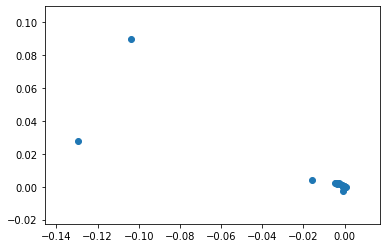

In [259]:
plt.scatter(lstm_values[0][0], lstm_values[0][1])

In [260]:
idx_seq = test_idxes[0, :20]
idx_seq

tensor([ 7, 16, 21, 19,  4, 14, 16, 20, 10, 19, 10, 17, 11, 11, 19,  4,  3, 10,
         4,  7])

In [261]:
events = [model.vocab.itos(x) for x in idx_seq.numpy()]
print(events)

['ingrown_nail', 'myopia', 'furosemide', 'ACL_tear', 'hay_fever', 'annual_physical', 'myopia', 'foot_pain', 'dental_exam', 'ACL_tear', 'dental_exam', 'eye_exam', 'peanut_allergy', 'peanut_allergy', 'ACL_tear', 'hay_fever', 'cut_finger', 'dental_exam', 'hay_fever', 'ingrown_nail']


In [262]:
model.vocab._vocab

{'<pad>': 0,
 '<unk>': 1,
 'cold_sore': 2,
 'cut_finger': 3,
 'hay_fever': 4,
 'PH': 5,
 'apnea': 6,
 'ingrown_nail': 7,
 'low_salt_diet': 8,
 'headache': 9,
 'dental_exam': 10,
 'peanut_allergy': 11,
 'ankle_sprain': 12,
 'backache': 13,
 'annual_physical': 14,
 'quad_injury': 15,
 'myopia': 16,
 'eye_exam': 17,
 'pneumonia': 18,
 'ACL_tear': 19,
 'foot_pain': 20,
 'furosemide': 21,
 'CHF': 22,
 'tachycardia': 23,
 'ARR': 24,
 'high_creatinine': 25,
 'resistent_hyp': 26,
 'PCI': 27,
 'normal_bmi': 28,
 'cardiac_rehab': 29,
 'ACE_inhibitors': 30,
 'AMI': 31}

In [44]:
lstm_values[0][0]

[0.11294358968734741,
 0.0312277190387249,
 -0.024547478184103966,
 -0.0033740245271474123,
 -0.001518900040537119,
 -0.0035624345764517784,
 -0.00207443255931139,
 -0.00013361229503061622,
 0.0003544994106050581,
 -0.002220567548647523,
 0.00105949304997921,
 -7.015465962467715e-05,
 0.00045359053183346987,
 0.001753794145770371,
 -0.006946766283363104,
 -0.01690535619854927,
 0.0,
 0.0,
 0.0,
 0.0]

In [45]:
len(lstm_values[0][0])

20

In [46]:
events

['ingrown_nail',
 'cut_finger',
 'annual_physical',
 'ankle_sprain',
 'ingrown_nail',
 'dental_exam',
 'dental_exam',
 'cold_sore',
 'cardiac_rehab',
 'annual_physical',
 'hay_fever',
 'annual_physical',
 'eye_exam',
 'cold_sore',
 'PCI',
 'ACE_inhibitors',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [47]:
df = pd.DataFrame()
df['events'] = events
df['shap_vals'] = lstm_values[0][0]

In [311]:
df

,events,shap_vals
0,hay_fever,0.363241
1,ACL_tear,0.003712
2,cut_finger,-0.058763
3,hay_fever,-0.018189
4,myopia,-0.000472
5,peanut_allergy,-0.006075
6,cut_finger,-0.011012
7,AMI,-0.006129
8,headache,-0.000996
9,quad_injury,0.000244


In [49]:
import seaborn as sns

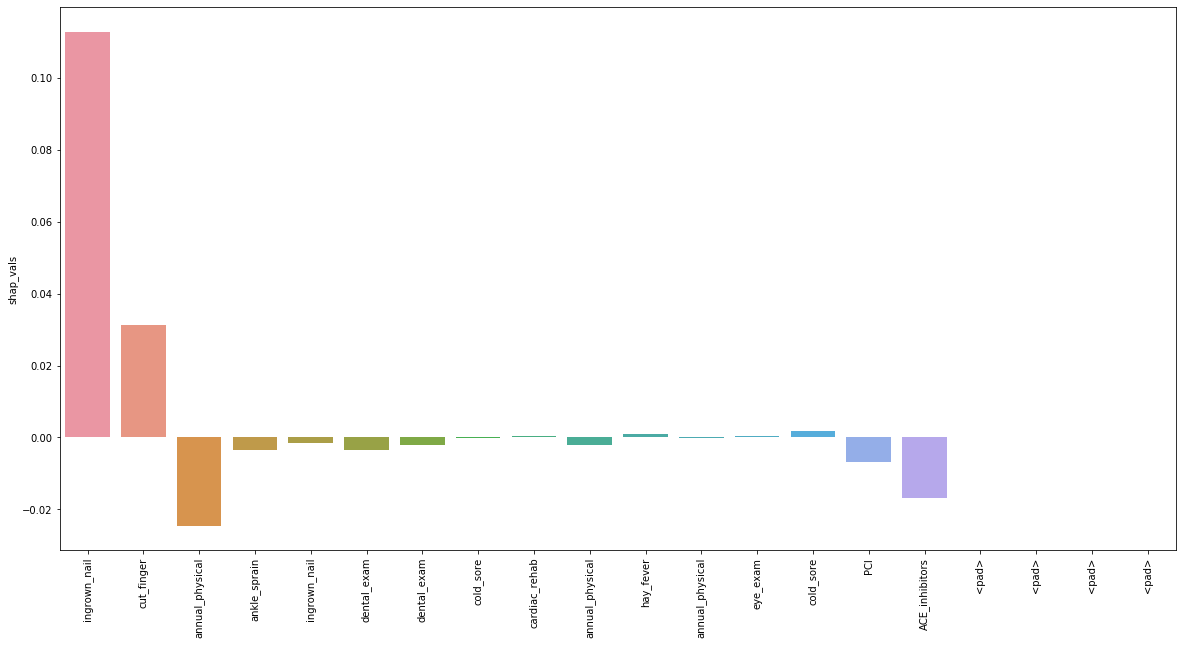

In [50]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=df.index, y=df.shap_vals, orient='v')
z = ax.set_xticklabels(df.events, rotation=90)

Scratchpad

In [42]:
from collections import defaultdict, OrderedDict, Counter

In [43]:
def create_word_score_ds(features_l, scores_l, model_name, explainer, labels=None):
    ds = []
    for review_idx, review in enumerate(features_l):    
        if labels != None: # if combination is lstm x shap
            d = defaultdict(lambda:[])
            actual_label = labels[review_idx]
            if actual_label == 0:
                tmp = scores_l[review_idx][0]
            else:
                tmp = scores_l[review_idx][1]
            for token_idx, token in enumerate(review):
                try:
                    d[token].append(abs(tmp[token_idx])) # append and take average
                except:
                    print(len(tmp))
            d = get_average_shap(d) # take average
            ds.append(d)
        else:
            d = {}
            tmp = scores_l[review_idx]
            for token_idx, token in enumerate(review):
                d[str(token)] = abs(tmp[str(token_idx)]) # take absolute numbers
            ds.append(d)
    return ds

In [44]:
ds = create_word_score_ds(test_data[0, :20], lstm_values, 'lstm-shap', explainer, labels=[0])

20
20
20
20
20
20
20
20
20
20
20
20


NameError: name 'get_average_shap' is not defined

In [ ]:
test_labels[0]